In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.preprocessing
from sklearn.metrics import r2_score
from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential

                     hour  dayofweek  quarter  month  year  dayofyear  \
Datetime                                                                
2004-12-31 01:00:00     1          4        4     12  2004        366   
2004-12-31 02:00:00     2          4        4     12  2004        366   
2004-12-31 03:00:00     3          4        4     12  2004        366   
2004-12-31 04:00:00     4          4        4     12  2004        366   
2004-12-31 05:00:00     5          4        4     12  2004        366   
...                   ...        ...      ...    ...   ...        ...   
2018-01-01 20:00:00    20          0        1      1  2018          1   
2018-01-01 21:00:00    21          0        1      1  2018          1   
2018-01-01 22:00:00    22          0        1      1  2018          1   
2018-01-01 23:00:00    23          0        1      1  2018          1   
2018-01-02 00:00:00     0          1        1      1  2018          2   

                     dayofmonth  weekofyear   AEP_

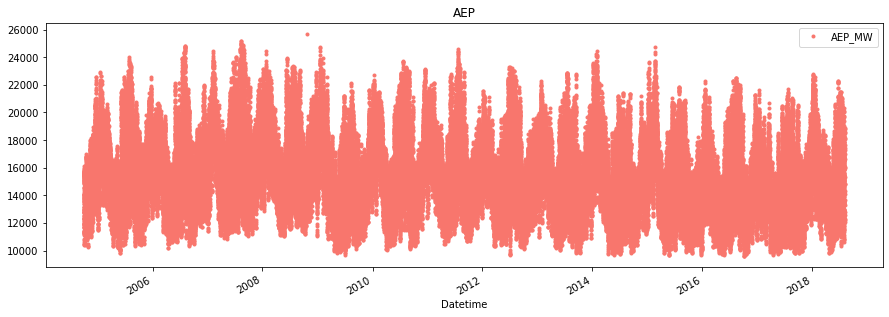

25695.0 9581.0


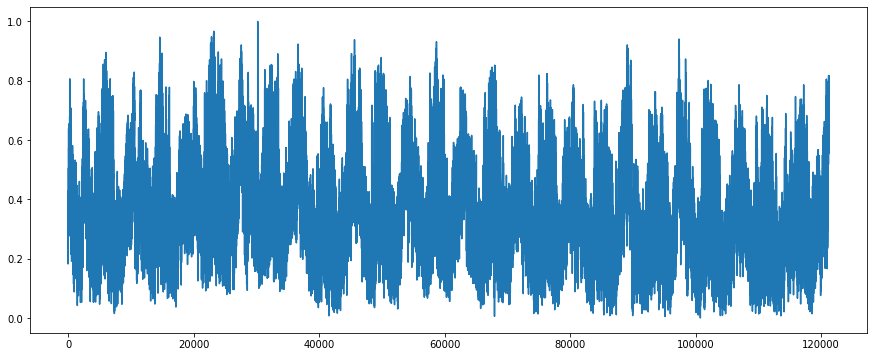

In [24]:
#Plotting hourly energy usage:

AEP = pd.read_csv('../input/hourly-energy-consumption/AEP_hourly.csv', index_col=[0], parse_dates=[0])

mau = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
bieudo = AEP.plot(style='.',figsize=(15,5), color=mau[0], title='AEP')

#Data transformation
def create_features(df, label=None):
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week

    X = df[['hour', 'dayofweek', 'quarter', 'month', 'year',
            'dayofyear', 'dayofmonth', 'weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(AEP, label='AEP_MW')
features_and_target = pd.concat([X, y], axis=1)
print(features_and_target)
plt.show()

plt.figure(figsize=(15,6))
data_csv = AEP.dropna()
dataset = data_csv.values
dataset = dataset.astype('float32')
max_value = np.max(dataset)
min_value = np.min(dataset)
scalar = max_value - min_value
dataset = list(map(lambda x: (x-min_value) / scalar, dataset))
plt.plot(dataset)
print(max_value, min_value)

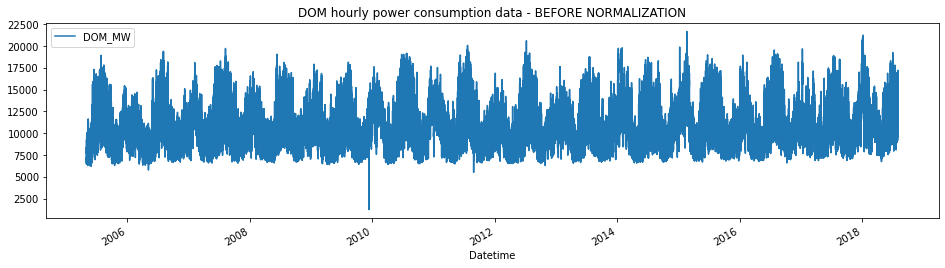

In [25]:
#choosing DOM_hourly.csv data for analysis
fpath='../input/hourly-energy-consumption/DOM_hourly.csv'

#Let's use datetime(2012-10-01 12:00:00,...) as index instead of numbers(0,1,...)
#This will be helpful for further data analysis as we are dealing with time series data
df = pd.read_csv(fpath, index_col='Datetime', parse_dates=['Datetime'])
df.head()

#checking missing data
df.isna().sum()

#Data visualization

df.plot(figsize=(16,4),legend=True)

plt.title('DOM hourly power consumption data - BEFORE NORMALIZATION')

plt.show()

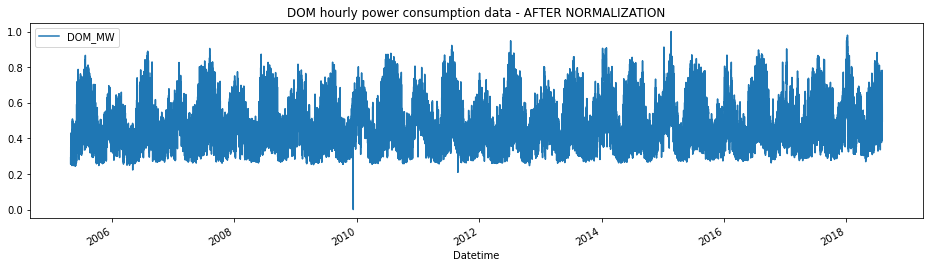

In [19]:
#Normalize DOM hourly power consumption data

def normalize_data(df):
    scaler = sklearn.preprocessing.MinMaxScaler()
    df['DOM_MW']=scaler.fit_transform(df['DOM_MW'].values.reshape(-1,1))
    return df

df_norm = normalize_data(df)
df_norm.shape

#Visualize data after normalization

df_norm.plot(figsize=(16,4),legend=True)

plt.title('DOM hourly power consumption data - AFTER NORMALIZATION')

plt.show()

In [26]:
# train data for deep learning models

def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i - seq_len: i, 0])
        y_train.append(stock.iloc[i, 0])

    # 1 last 6189 days are going to be used in test
    X_test = X_train[110000:]
    y_test = y_train[110000:]

    # 2 first 110000 days are going to be used in training
    X_train = X_train[:110000]
    y_train = y_train[:110000]

    # 3 convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    X_test = np.array(X_test)
    y_test = np.array(y_test)

    # 4 reshape data to input into RNN models
    X_train = np.reshape(X_train, (110000, seq_len, 1))

    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))

    return [X_train, y_train, X_test, y_test]

In [21]:
#create train, test data
seq_len = 20 #choose sequence length

X_train, y_train, X_test, y_test = load_data(df, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (110000, 20, 1)
y_train.shape =  (110000,)
X_test.shape =  (6169, 20, 1)
y_test.shape =  (6169,)


In [ ]:
#RNN model
rnn_model = Sequential()
rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn_model.add(Dropout(0.15))
rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))
rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=False))
rnn_model.add(Dropout(0.15))
rnn_model.add(Dense(1))
rnn_model.summary()
rnn_model.compile(optimizer="adam",loss="MSE")
rnn_model.fit(X_train, y_train, epochs=5, batch_size=1000)

In [27]:
#r2 score for the values predicted by the above trained SIMPLE RNN model

rnn_predictions = rnn_model.predict(X_test)
rnn_score = r2_score(y_test,rnn_predictions)
print("R2 Score of RNN model = ",rnn_score)

R2 Score of RNN model =  0.8999639856585073


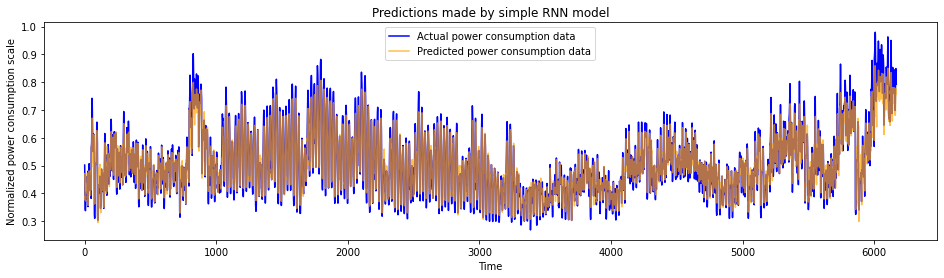

In [28]:
# compare the actual values vs predicted values by plotting a graph

def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16, 4))
    plt.plot(test, color='blue', label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='orange', label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()
plot_predictions(y_test, rnn_predictions, "Predictions made by simple RNN model")

In [30]:
#train model for LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))
lstm_model.add(LSTM(40,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.15))
lstm_model.add(LSTM(40,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.15))
lstm_model.add(Dense(1))
lstm_model.summary()
lstm_model.compile(optimizer="adam",loss="MSE")
lstm_model.fit(X_train, y_train, epochs=5, batch_size=1000)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 20, 40)            6720      
_________________________________________________________________
dropout_12 (Dropout)         (None, 20, 40)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 20, 40)            12960     
_________________________________________________________________
dropout_13 (Dropout)         (None, 20, 40)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 40)                12960     
_________________________________________________________________
dropout_14 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [31]:
#r2 score for the values predicted by the above trained LSTM model
lstm_predictions = lstm_model.predict(X_test)
lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model = ",lstm_score)

R^2 Score of LSTM model =  0.8293259922362423


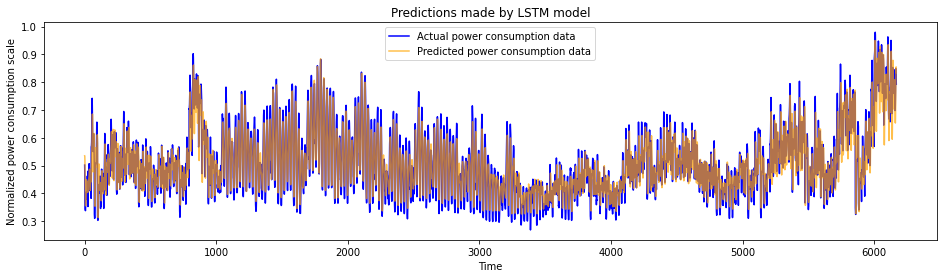

In [32]:
#actual values vs predicted values by plotting a graph
plot_predictions(y_test, lstm_predictions, "Predictions made by LSTM model")

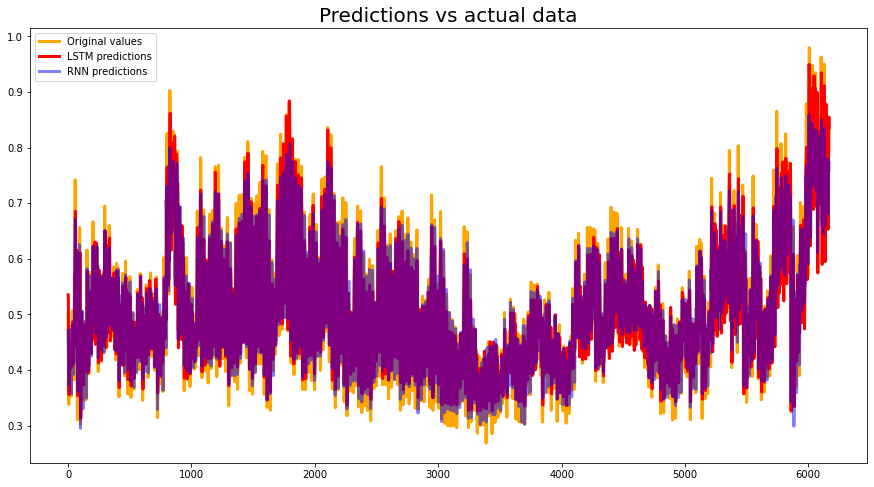

In [33]:
#RNN, LSTM model by plotting data in a single graph
plt.figure(figsize=(15,8))
plt.plot(y_test, c="orange", linewidth=3, label="Original values")
plt.plot(lstm_predictions, c="red", linewidth=3, label="LSTM predictions")
plt.plot(rnn_predictions, alpha=0.5, c="blue", linewidth=3, label="RNN predictions")
plt.legend()
plt.title("Predictions vs actual data", fontsize=20)
plt.show()